# **Import des Datasets**

In [4]:
# Demange Aymeric 02/10/2020
#TP de machine learning sur deux datasets de fraude


import seaborn as sns
import pandas as pd
import warnings

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import metrics



warnings.filterwarnings("ignore")

sns.set

labelencoder = preprocessing.LabelEncoder()

# charger le dataset
ipAdress = pd.read_csv(r"/content/IpAddress_to_Country.csv")
fraud = pd.read_csv(r"/content/Fraud_Data.csv")
ipAdress_df = ipAdress
fraud_df = fraud

In [5]:
# On peut observer que notre target c'est la colonne "class"
# Beaucoup de colonnes sont des variables qualitatives qu'il vas falloir transformer si on les gardes
fraud_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,0.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,0.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,0.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39.0,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...
88712,24716,2015-02-26 13:07:18,2015-06-19 02:42:47,14.0,BNDYFXDDTUXLR,Ads,Chrome,F,36.0,2.327731e+09,0.0
88713,178447,2015-04-08 23:30:13,2015-07-25 09:41:39,71.0,FMFYFNPJCPUJO,SEO,Safari,M,41.0,4.050620e+09,1.0
88714,3465,2015-01-13 06:12:57,2015-03-15 21:36:10,40.0,GFRVIWTFLKVCG,Ads,Chrome,M,24.0,4.737165e+08,0.0
88715,62673,2015-06-22 14:34:40,2015-08-03 02:08:12,34.0,FKNWNYADTONLN,Ads,Chrome,M,42.0,1.319890e+09,0.0


In [6]:
# Un lot d'adresse ip avec une plage basse et haute
ipAdress_df

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


# **DATA WRANGLING**


In [7]:
# Je décide de drop tous les na dans les datasets afin de supprimer d'éventuels exemples érronés 
fraud_df = fraud_df.dropna()
ipAdress_df = ipAdress_df.dropna()

In [8]:
# Je vais ensuite transformer mes colonnes qualitative en donnée quantitative via la méthode : "labelencoder"
# Cette méthode permet de trouver toutes les différentes valeur présentes dans une colonne et d'associer une valeur numérique à la place. 
# Si deux valeurs sont identiques elles prennent le même nombre

fraud_df['source'] = labelencoder.fit_transform(fraud_df['source'])
fraud_df['browser'] = labelencoder.fit_transform(fraud_df['browser'])
fraud_df['device_id'] = labelencoder.fit_transform(fraud_df['device_id'])


# Je drop signup_time et purchase_time car se sont des colonnes de date, une fraude peut arriver à n'importe qu'elle heure via des scripts/tâche planifiés ou tout simplement
# l'emploi du temps du fraudeurs.

fraud_df = fraud_df.drop(['signup_time','purchase_time'], axis= 1)


# La colonne "sex" possède des valeurs qui peuvent être transformé en booléen. J'utilise la méthode cat.codes

fraud_df.sex = fraud_df['sex'].astype('category').cat.codes
fraud_df,ipAdress_df

(       user_id  purchase_value  device_id  ...   age    ip_address  class
 0        22058            34.0      53632  ...  39.0  7.327584e+08    0.0
 1       333320            16.0      14559  ...  53.0  3.503114e+08    0.0
 2         1359            15.0      78723  ...  53.0  2.621474e+09    1.0
 3       150084            44.0       2437  ...  41.0  3.840542e+09    0.0
 4       221365            39.0      41318  ...  45.0  4.155831e+08    0.0
 ...        ...             ...        ...  ...   ...           ...    ...
 88711   254639            12.0      68234  ...  27.0  3.288269e+09    0.0
 88712    24716            14.0       4850  ...  36.0  2.327731e+09    0.0
 88713   178447            71.0      17479  ...  41.0  4.050620e+09    1.0
 88714     3465            40.0      19881  ...  24.0  4.737165e+08    0.0
 88715    62673            34.0      17289  ...  42.0  1.319890e+09    0.0
 
 [88716 rows x 9 columns],
         lower_bound_ip_address  upper_bound_ip_address    country
 0  

# **MERGING DES DEUX DATASETS**

In [9]:
# L'objectif de ses deux datasets est de relier les addresses IP des fraudeurs a des plages d'adresses IP

# On vas donc merge les deux dataframes. On vas prendre chaque adresse IP et regarder dans quelle plage d'IP elle se trouve, dès qu'on trouve la plage, on associe country à la position

def IP_to_country(ip) :
    try :
        return ipAdress_df.country[(ipAdress_df.lower_bound_ip_address <= ip)
                                & 
                                (ipAdress_df.upper_bound_ip_address >= ip)].iloc[0]
    except IndexError :
        return "Unknown"
fraud_df["IP_country"] = fraud_df.ip_address.apply(IP_to_country)

In [10]:
# On peut donc voir que notre nouveau dataFrame fraud_df possède la colonne "IP_country".

fraud_df

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,34.0,53632,2,0,1,39.0,7.327584e+08,0.0,Japan
1,333320,16.0,14559,0,0,0,53.0,3.503114e+08,0.0,United States
2,1359,15.0,78723,2,3,1,53.0,2.621474e+09,1.0,United States
3,150084,44.0,2437,2,4,1,41.0,3.840542e+09,0.0,Unknown
4,221365,39.0,41318,0,4,1,45.0,4.155831e+08,0.0,United States
...,...,...,...,...,...,...,...,...,...,...
88711,254639,12.0,68234,2,0,0,27.0,3.288269e+09,0.0,Italy
88712,24716,14.0,4850,0,0,0,36.0,2.327731e+09,0.0,Switzerland
88713,178447,71.0,17479,2,4,1,41.0,4.050620e+09,1.0,Unknown
88714,3465,40.0,19881,0,0,1,24.0,4.737165e+08,0.0,United States


# **DATA CLEANING**

avec un petit peu de reformatage de donnée

In [11]:
#On s'aperçoit que certaine ligne possède une valeur appelé "Unknown" car l'ip ne faisait partie d'aucune plage de donnée, on va les supprimés
fraud_df = fraud_df[fraud_df.IP_country != 'Unknown']
fraud_df

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,34.0,53632,2,0,1,39.0,7.327584e+08,0.0,Japan
1,333320,16.0,14559,0,0,0,53.0,3.503114e+08,0.0,United States
2,1359,15.0,78723,2,3,1,53.0,2.621474e+09,1.0,United States
4,221365,39.0,41318,0,4,1,45.0,4.155831e+08,0.0,United States
5,159135,42.0,1438,0,0,1,18.0,2.809315e+09,0.0,Canada
...,...,...,...,...,...,...,...,...,...,...
88709,28399,47.0,41993,2,2,0,22.0,5.202187e+08,0.0,Poland
88711,254639,12.0,68234,2,0,0,27.0,3.288269e+09,0.0,Italy
88712,24716,14.0,4850,0,0,0,36.0,2.327731e+09,0.0,Switzerland
88714,3465,40.0,19881,0,0,1,24.0,4.737165e+08,0.0,United States


In [12]:
# J'isole ma target
Y = fraud_df['class']
Y

0        0.0
1        0.0
2        1.0
4        0.0
5        0.0
        ... 
88709    0.0
88711    0.0
88712    0.0
88714    0.0
88715    0.0
Name: class, Length: 75740, dtype: float64

In [13]:
# J'isole mes features en supprimant ma target et l'adresse IP qui n'a plus d'interet ici 
X = fraud_df.drop(['ip_address','class'], axis = 1)
X

,user_id,purchase_value,device_id,source,browser,sex,age,IP_country
0,22058,34.0,53632,2,0,1,39.0,Japan
1,333320,16.0,14559,0,0,0,53.0,United States
2,1359,15.0,78723,2,3,1,53.0,United States
4,221365,39.0,41318,0,4,1,45.0,United States
5,159135,42.0,1438,0,0,1,18.0,Canada
...,...,...,...,...,...,...,...,...
88709,28399,47.0,41993,2,2,0,22.0,Poland
88711,254639,12.0,68234,2,0,0,27.0,Italy
88712,24716,14.0,4850,0,0,0,36.0,Switzerland
88714,3465,40.0,19881,0,0,1,24.0,United States


In [14]:
# Ma nouvelle colonne Ip_country est en string je transforme comme pour les autres variables qualitative en variable quantitative
X['IP_country'] = labelencoder.fit_transform(X['IP_country'])
# Essaie non fructueux de reverse le transform
# X['IP_country'] = labelencoder.inverse_transform(X['IP_country'])
X

,user_id,purchase_value,device_id,source,browser,sex,age,IP_country
0,22058,34.0,53632,2,0,1,39.0,81
1,333320,16.0,14559,0,0,0,53.0,164
2,1359,15.0,78723,2,3,1,53.0,164
4,221365,39.0,41318,0,4,1,45.0,164
5,159135,42.0,1438,0,0,1,18.0,31
...,...,...,...,...,...,...,...,...
88709,28399,47.0,41993,2,2,0,22.0,129
88711,254639,12.0,68234,2,0,0,27.0,79
88712,24716,14.0,4850,0,0,0,36.0,151
88714,3465,40.0,19881,0,0,1,24.0,164


In [ ]:
# A cause du temps de merging j'ai décidé de faire un export du dataset mergé
fraud_df.to_csv("/content/Final_df.csv")

In [15]:
# On vas split notre environnement de travail en 2 grandes parties : L'environnement de prod (test) et d'entrainement (train)
# On vérifie la shape de nos variables afin de s'assurer de possèder le bon nombre de colonnes et de lignes
splits = train_test_split(X,Y,
                          random_state=0)

for each in splits:
  print(each.shape)
X_train, X_test, Y_train, Y_test = splits
scaler = StandardScaler()

(56805, 8)
(18935, 8)
(56805,)
(18935,)


In [16]:
# Petite fonction permettant de calculer l'accuracy et ensuite de le mettre en %
def accuracy(preds, Y):
  return ((preds == Y).sum() / len(Y)* 100)

# **ENTRAINEMENT DE NOTRE MODELE**

In [108]:
# On applique l'algorithme RandomForest
rf = RF()
rf.fit(X_train,Y_train)
prediction = rf.predict(X_test)
proba = rf.predict_proba(X_test)
print(prediction)
print(proba)

[0. 0. 0. ... 0. 0. 0.]
[[0.96 0.04]
 [0.84 0.16]
 [0.97 0.03]
 ...
 [0.9  0.1 ]
 [0.96 0.04]
 [0.98 0.02]]


**Accuracy**

In [18]:
# On observe une accuracy de 94% dans ce test avec comme hyperparamètre random_state=0
accuracy(prediction,Y_test)

93.41431212041194

**L'importance de chaque feature**

In [19]:
# Ici on vas réentrainer notre model pour faire un test d'importance sur nos features
rf.fit(X_train, Y_train)
importance = rf.feature_importances_
importance

array([0.2230858 , 0.17648937, 0.26543175, 0.02996117, 0.03275044,
       0.01950265, 0.15217709, 0.10060173])

**Affichage en %/100 de l'importance de nos features**

Somme des pouvoirs predictif : 1.0


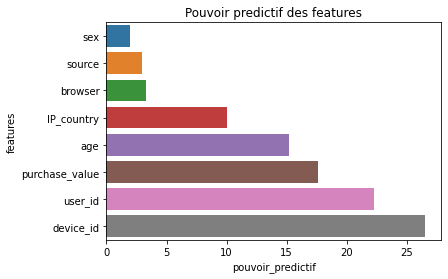

In [20]:
# Une fois l'importance réalisé on vas la plot afin mieux observer à quel point une feature peut faire varier notre accuracy
# Je crée un nouveau dataframe pour pouvoir stocker seulement les colonnes qui m'intéresse

d = pd.DataFrame()
d['features'] = X_train.columns
d['pouvoir_predictif'] = importance
print('Somme des pouvoirs predictif : {}'.format(d['pouvoir_predictif'].sum()))
d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
d = d.sort_values(by='pouvoir_predictif', ascending=True)
sns.barplot(d['pouvoir_predictif'], d['features']).set_title('Pouvoir predictif des features');

# **Explication du graphique ci-dessus**
Dans ce graphique on peut observer en abscisse le pouvoir prédictif qui correspond à l'influence que peut avoir une feature sur notre accuracy
En ordonnée ce sont toutes nos features utilisés pour faire nos prédictions et teste d'accuracy.

L'unité de l'abscisse est un % qui lorsque l'on cumule chaque feature arrive à 100.

On peut clairement voir que la feature qui impacte le plus notre accuracy  est le device_id qui correspond au nom de la machine qu'utilise le fraudeur. Il est donc censé de ce dire que lorsque l'on identifie le device d'un fraudeur celui-ci vas probablement recommencé avec la même machine. On peut doncre prendre des mesures contre ce genre de fraudeur.

In [21]:
d

,features,pouvoir_predictif
5,sex,1.950265
3,source,2.996117
4,browser,3.275044
7,IP_country,10.060173
6,age,15.217709
1,purchase_value,17.648937
0,user_id,22.308580
2,device_id,26.543175


In [22]:
# Ici on fait une matrice de confusion nous permettant d'observer le nombre de faux positif ou faux négatif.
from sklearn.metrics import confusion_matrix
proba = confusion_matrix(Y_test,prediction)
proba

array([[17062,    70],
       [ 1177,   626]])

Text(0.5, 1.0, 'Nombre de fraude en fonction du pays')

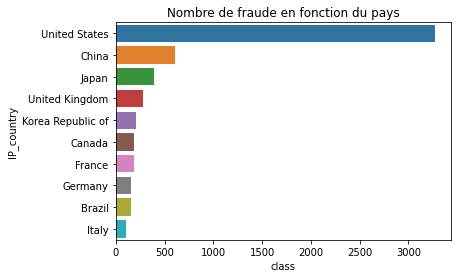

In [23]:
# J'affiche le nombre de fraude en fonction des 10premiers pays
# Pour ça je récupère les colonnes class et ip country et en fait un nouveau dataframe
# Je ne souhaite garder que les cas ou la fraude à été prédit.

#Je groupby pour sur ip_country et additionne la colonne class en fonction des pays

attack_df = fraud_df[fraud_df['class'] == 1]
attack_df = attack_df[['class','IP_country']]
attack_df = attack_df[attack_df.IP_country != 'Unknown']

attack_df

total_attack = attack_df.groupby(by='IP_country', as_index=False).sum().sort_values(by='class', ascending = False)
total_attack.head(15)

sns.barplot(total_attack['class'], total_attack['IP_country'][:10]).set_title('Nombre de fraude en fonction du pays')

# **Courbe ROC et AUC score**

In [102]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import numpy as np

In [103]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [104]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), proba[:, i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

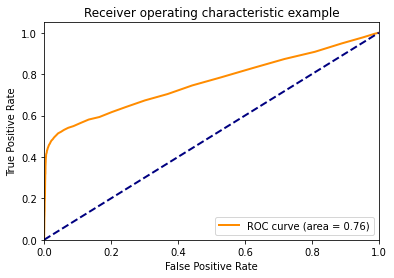

In [105]:

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [106]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

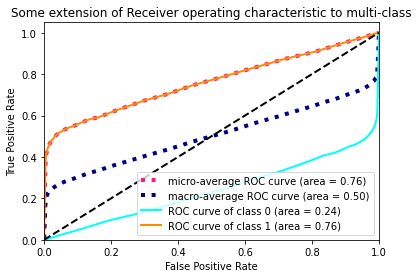

In [107]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [93]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(Y_test, proba[:, i])

In [96]:
roc_auc_scores = metrics.roc_auc_score(Y_test, proba[:, i])
roc_auc_scores

0.7599938826111409

In [97]:
dftp = pd.DataFrame(dict(fpr=fpr0, tpr=tpr0, threshold=thresholds0)).copy()
dftp.head(n=2)

,fpr,tpr,threshold
0,0.0,0.000000,2.0
1,0.0,0.000555,1.0


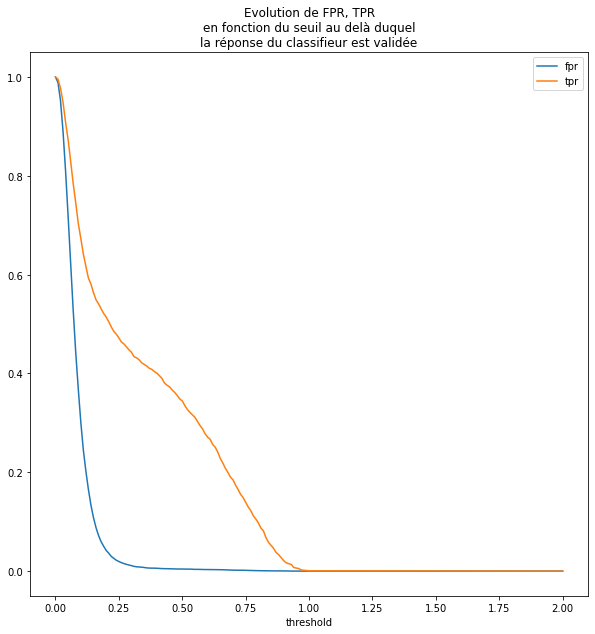

In [98]:
ax = dftp.plot(x="threshold", y=['fpr', 'tpr'], figsize=(10, 10))
ax.set_title("Evolution de FPR, TPR\nen fonction du seuil au delà duquel\n" +
             "la réponse du classifieur est validée");

# **Conclusion**
Au vu de l'étude faite sur les deux datasets, notre algorithme peut prédire à 94% si une personne fraude. Il est possible d'identifier sur quel device et quel utilisateur fraude. 
Une très grande majorité des fraudeurs sont basé aux États-Unis, je recommande donc de vérifier si le marché américain est celui que l'application vise ou alors de prendre des mesures de précautions plus grande lorsqu'un utilisateur s'enregistre depuis une IP américaine afin de prévenir d'éventuel fraude.